In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/nassim/dev/reinforcement-learning


In [2]:
import sys
import numpy as np
import matplotlib
from collections import defaultdict
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

# Environment

In [4]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 20 else 1

for i_episode in range(5):
    observation = env.reset()
    for step in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking action: {}".format( ["Stick", "Hit"][action]))
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print("Game end. Reward: {}\n".format(float(reward)))
            break




Player Score: 17 (Usable Ace: False), Dealer Score: 5
Taking action: Hit
Player Score: 21 (Usable Ace: False), Dealer Score: 5
Taking action: Stick
Player Score: 21 (Usable Ace: False), Dealer Score: 5
Game end. Reward: 1.0

Player Score: 20 (Usable Ace: False), Dealer Score: 8
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 8
Game end. Reward: 1.0

Player Score: 14 (Usable Ace: False), Dealer Score: 6
Taking action: Hit
Player Score: 23 (Usable Ace: False), Dealer Score: 6
Game end. Reward: -1.0

Player Score: 19 (Usable Ace: False), Dealer Score: 6
Taking action: Hit
Player Score: 20 (Usable Ace: False), Dealer Score: 6
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 6
Game end. Reward: 1.0

Player Score: 19 (Usable Ace: False), Dealer Score: 9
Taking action: Hit
Player Score: 29 (Usable Ace: False), Dealer Score: 9
Game end. Reward: -1.0



# MC Prediction

In [5]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate episode
        episode = []
        state = env.reset()
        for step in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Compute return
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # First-visit MC: only the first visit of a state is counted
            first_visit_idx = next(i for i, x in enumerate(episode) if x[0] == state)
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[first_visit_idx:])])

            # Compute value function as the average returns for the state over all samples
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    
    return V



In [6]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

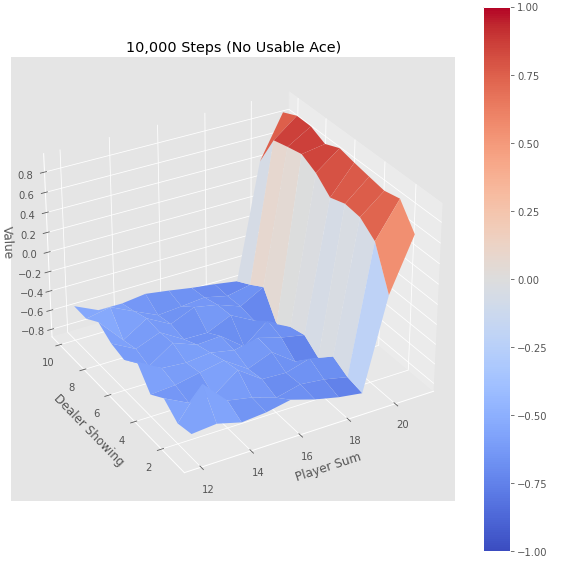

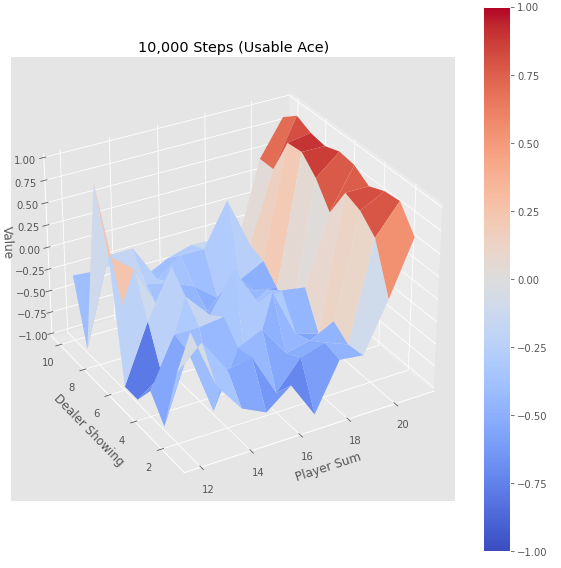

Episode 500000/500000.

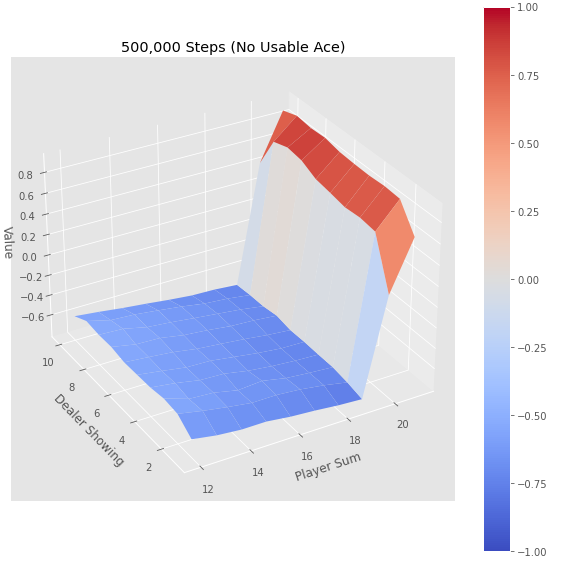

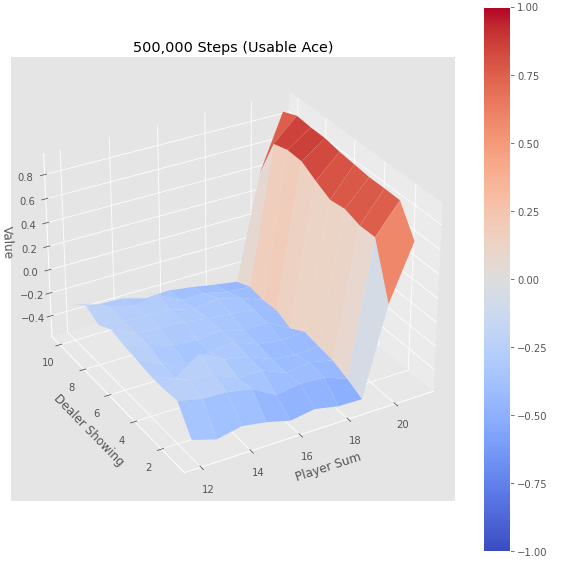

In [7]:

V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")



# MC Control (On-Policy ε-Greedy)

In [8]:
def epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0-epsilon)
        return A
    return policy_fn

In [9]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate episode
        episode = []
        state = env.reset()
        for step in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Compute return
        state_actions_in_episode = set([tuple((x[0], x[1])) for x in episode])
        for state_action in state_actions_in_episode:

            # First-visit MC: only the first visit of an action-state is counted
            first_visit_idx = next(i for i, x in enumerate(episode) if x[0] == state_action[0] and x[1] ==  state_action[1])
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[first_visit_idx:])])

            # Compute Q function as the average returns for the action-states over all samples
            returns_sum[state_action] += G
            returns_count[state_action] += 1.0
            Q[state_action[0]][state_action[1]] = returns_sum[state_action] / returns_count[state_action]

            # The policy is improved implicity by changing the Q dictionary

    return Q, policy



In [10]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

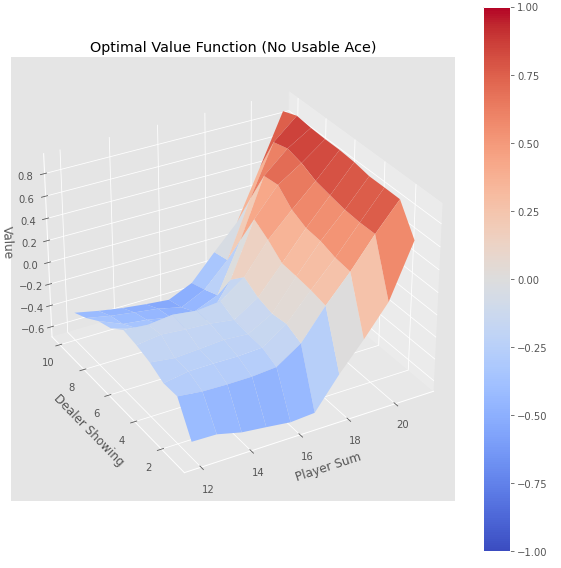

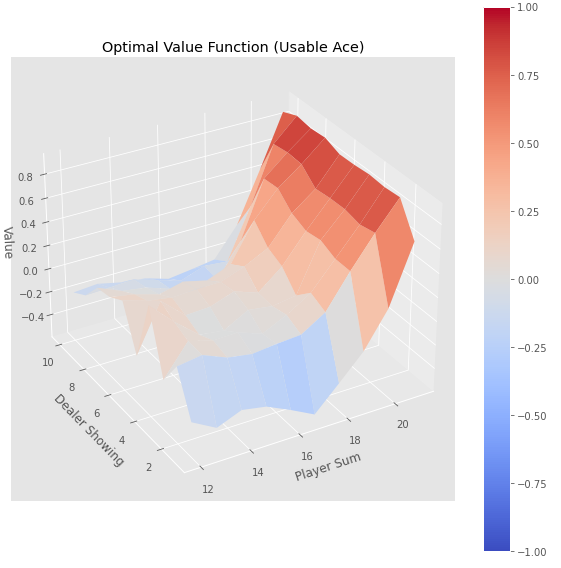

In [11]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

# MC Control (Off-Policy w/ Weighted Important Sampling)


In [16]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn



In [23]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Cumulative sum denominator of the weighted importance sampling 
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate episode
        episode = []
        state = env.reset()
        for step in range(100):
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        G = 0
        W = 1
        # Loop for each step of the episode backwards
        # Not using the book's t-notation, instead indexing with state-actions
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            C[state][action] += W
            # Incremental action-values update from (5.8)
            Q[state][action] += W/C[state][action]*(G - Q[state][action])
            # This is because the target policy is greedy
            if action != np.argmax(target_policy(state)):
                break
            W = W * target_policy(state)[action] / behavior_policy(state)[action]

    return Q, target_policy

In [24]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

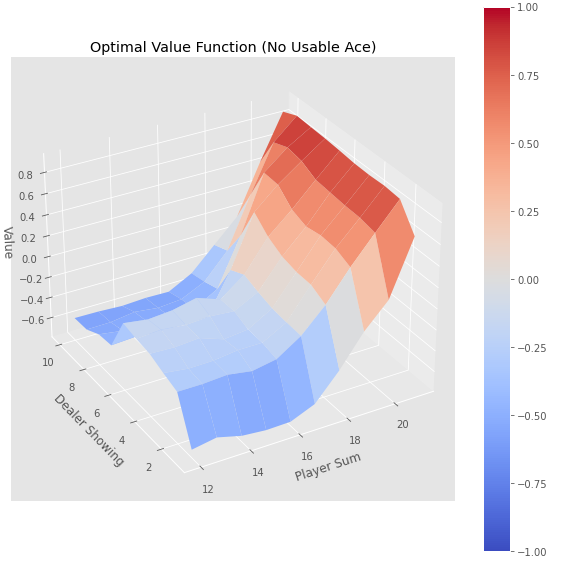

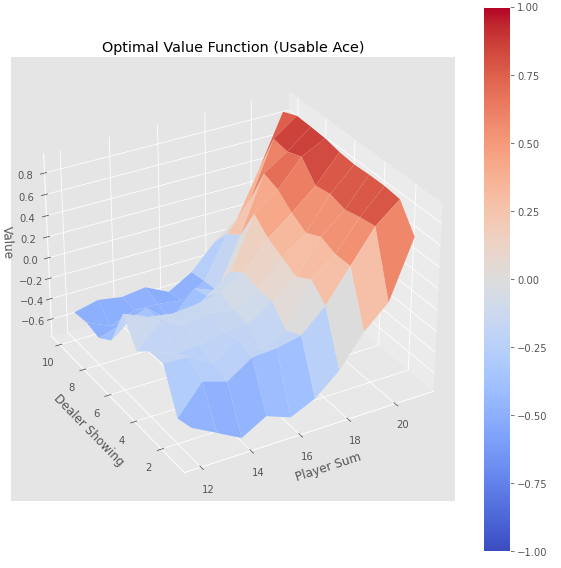

In [25]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

